# Auto-Encoder Proof-Of-Concept

In [22]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

sys.path.append(os.path.join(os.pardir, os.pardir))
from amlutils.task2.loading import load_train_set

from IPython.display import display

In [10]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [11]:
X_train, y_train = load_train_set(os.path.join(os.pardir, 'data'))

display(X_train)

#X_train = X_train.fillna(0.0)
# Small hack, want that each signal is betweeb -1 and 1, so need to make
# signals the features and transform, then switch back.
X_train_scaled = X_train.T
X_train_scaled.values[:] = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_scaled)
X_train_scaled = X_train_scaled.T

X_train = X_train.fillna(0.0)
X_train_scaled = X_train_scaled.fillna(0.0)

display(X_train_scaled)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
id,,,,,,,,,,,,,,,,,,,,,
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,505,500,496,492,487,480,475,476,483,495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-21,-16,-12,-7,-3,0,1,2,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-211,-457,-635,-710,-715,-663,-573,-481,-401,-337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,32,29,25,22,19,17,15,12,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-285,-303,-334,-376,-413,-432,-443,-451,-460,-468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,50,51,50,48,46,44,42,39,36,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,-207,-225,-242,-258,-266,-271,-275,-279,-281,-284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
id,,,,,,,,,,,,,,,,,,,,,
0,-0.646817,-0.650924,-0.657084,-0.663244,-0.669405,-0.673511,-0.679671,-0.691992,-0.698152,-0.685832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.579039,0.570306,0.563319,0.556332,0.547598,0.535371,0.526638,0.528384,0.540611,0.561572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.255070,-0.251170,-0.248050,-0.244150,-0.241030,-0.238690,-0.237910,-0.237129,-0.235569,-0.234789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.237054,-0.520138,-0.724971,-0.811277,-0.817031,-0.757192,-0.653625,-0.547756,-0.455696,-0.382048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.091808,0.086158,0.081921,0.076271,0.072034,0.067797,0.064972,0.062147,0.057910,0.055085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-0.004863,-0.015805,-0.034650,-0.060182,-0.082675,-0.094225,-0.100912,-0.105775,-0.111246,-0.116109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5113,-0.322902,-0.320057,-0.322902,-0.328592,-0.334282,-0.339972,-0.345661,-0.354196,-0.362731,-0.371266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5114,-0.331458,-0.351716,-0.370850,-0.388858,-0.397862,-0.403489,-0.407991,-0.412493,-0.414744,-0.418120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


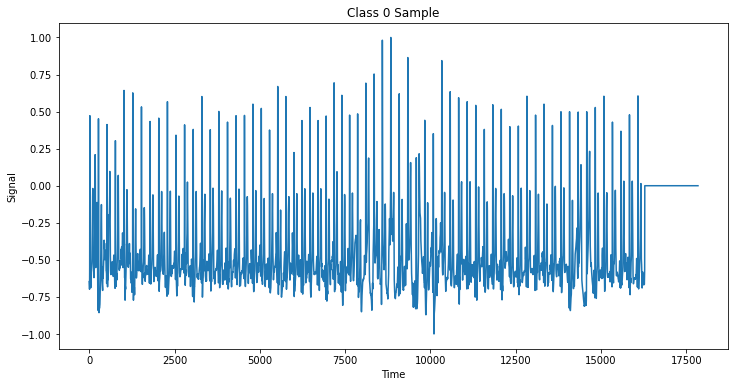

In [12]:
# Compare original with auto-encoded signal.
num_rows = 1
num_cols = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12 * num_cols,6 * num_rows))

fig.set_facecolor('white')

axs.plot(list(range(17842)), X_train_scaled.iloc[0])
axs.set(xlabel='Time', ylabel='Signal', title='Class 0 Sample')

plt.show()

In [13]:
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float)
# Unsqueeze X tensor to have another dimension representing the channel, this
# is needed for convolutions.
X_train_tensor = torch.unsqueeze(X_train_tensor, 1)
y_train_tensor = torch.tensor(y_train.values)

train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_tensor, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
# Architecture based on: https://pythonwife.com/convolutional-autoencoders-opencv/

class ConvAutoEncoder(pl.LightningModule):

    def __init__(self) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=10, stride=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.AvgPool1d(kernel_size=10, stride=2),
            nn.Dropout(p=0.3),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=10, stride=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Upsample(size=17842),
            nn.Dropout(p=0.3),
        )

    def forward(self, X):
        embedding = self.encoder(X)
        return embedding

    def reconstruct(self, X):
        Z = self.encoder(X)
        X_hat = self.decoder(Z)
        return X_hat

    def training_step(self, batch, batch_idx):
        X, y = batch
        X_hat = self.reconstruct(X)
        loss = F.mse_loss(X_hat, X)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [30]:
ecg_auto_encoder = ConvAutoEncoder()

trainer = pl.Trainer(callbacks=[EarlyStopping(monitor="train_loss")])
trainer.fit(ecg_auto_encoder, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 13    
1 | decoder | Sequential | 13    
---------------------------------------
26        Trainable params
0         Non-trainable params
26        Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/80 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 20: 100%|██████████| 80/80 [00:12<00:00,  6.47it/s, loss=0.0429, v_num=5]


In [32]:
trainer.save_checkpoint("ecg-auto-encoder.ckpt")

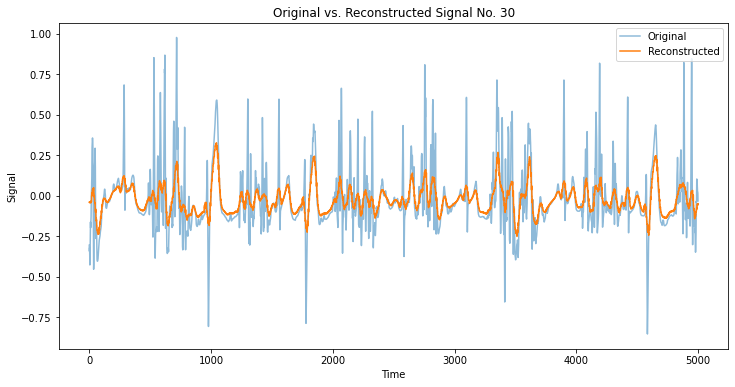

In [31]:
# Compare original with auto-encoded signal.
num_rows = 4
num_cols = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12 * num_cols, 8 * num_rows))

fig.set_facecolor('white')

samples = [0, 3, 4, 30]
opacity = 0.25
time_limit = 5000


with torch.no_grad():
    ecg_auto_encoder.eval()

    for plot_idx, sample in enumerate(samples):
        axs[plot_idx].plot(list(range(time_limit)), X_train_scaled.iloc[sample, np.r_[:time_limit]], alpha=opacity, label='Original')

        signal_tensor = torch.tensor(X_train_scaled.iloc[sample].values, dtype=torch.float)
        signal_tensor = torch.unsqueeze(signal_tensor, 0)
        signal_tensor = torch.unsqueeze(signal_tensor, 0)
        enc_dec_signal = ecg_auto_encoder.reconstruct(signal_tensor)
        enc_dec_signal = torch.squeeze(enc_dec_signal)

        axs[plot_idx].plot(list(range(time_limit)), enc_dec_signal[:time_limit], label='Reconstructed')
        axs[plot_idx].set(xlabel='Time', ylabel='Signal', title=f'Original vs. Reconstructed Signal No. {sample}')
        axs[plot_idx].legend(loc='upper right')

plt.show()

## Classification with Encoded Signals

In [33]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [42]:
# Compute encoded version of training set.
with torch.no_grad():
    ecg_auto_encoder.eval()
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float)
    display(X_train_tensor.shape)
    X_train_enc = ecg_auto_encoder(signal_tensor)
    display(X_train_enc.shape)
    X_train_enc = torch.squeeze(X_train_enc)
    X_train_enc = pd.DataFrame(X_train_enc.numpy())#, index=X_train.index)
    display(X_train_enc)

torch.Size([5117, 17842])

torch.Size([1, 1, 2968])

,0
0,-0.050724
1,0.004449
2,0.025024
3,0.167546
4,0.144093
...,...
2963,0.041777
2964,0.041777
2965,0.041777
2966,0.041777


In [ ]:
enc_valid_score = cross_val_score(
    LinearSVC(tol=1e-2),
    X_train_enc,
    pd.Series.ravel(y_train),
    cv=5,
    scoring='f1_micro',
    verbose=4,
    n_jobs=-1).mean()
print(enc_valid_score)

In [ ]:
raw_valid_score = cross_val_score(
    LinearSVC(tol=1e-2),
    X_train,
    pd.Series.ravel(y_train),
    cv=5,
    scoring='f1_micro',
    verbose=4,
    n_jobs=-1).mean()
print(raw_valid_score)